__1.	Необходимо доработать обучение нейросети, что мы разбирали на уроке.(Посмотрите чего не хватает в процессе обучения и подготовки данных)__

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                               title                                                 size  lastUpdated          downloadCount  
----------------------------------------------------------------  --------------------------------------------------  ------  -------------------  -------------  
nehaprabhavalkar/indian-food-101                                  Indian Food 101                                        7KB  2020-09-30 06:23:43           3849  
christianlillelund/donald-trumps-rallies                          Donald Trump's Rallies                               720KB  2020-09-26 10:25:08           1000  
heeraldedhia/groceries-dataset                                    Groceries dataset                                    257KB  2020-09-17 04:36:08           4682  
andrewmvd/trip-advisor-hotel-reviews                              Trip Advisor Hotel Reviews                             5MB  2020-09-30 08:31:20           2727  
balraj98/stanford-back

In [ ]:
!mkdir -p SDC
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge
!unzip -qq lyft-udacity-challenge.zip -d SDC/
!rm lyft-udacity-challenge.zip

100% 5.11G/5.11G [01:46<00:00, 19.9MB/s]
100% 5.11G/5.11G [01:46<00:00, 51.3MB/s]


In [ ]:
labels = ['Unlabeled', 'Building', 'Fence', 
          'Other', 'Pedestrian', 'Pole', 
          'Roadline', 'Road', 'Sidewalk', 
          'Vegetation', 'Car', 'Wall', 'Traffic sign']

In [ ]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk('SDC'):
    for name in files:
        f = os.path.join(root, name)
        if 'CameraRGB' in f:
            cameraRGB.append(f)
        elif 'CameraSeg' in f:
            cameraSeg.append(f)
        else:
            break

df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
df.sort_values(by='cameraRGB',inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.head(5))

                                 cameraRGB                                cameraSeg
0  SDC/dataA/dataA/CameraRGB/02_00_000.png  SDC/dataA/dataA/CameraSeg/02_00_000.png
1  SDC/dataA/dataA/CameraRGB/02_00_001.png  SDC/dataA/dataA/CameraSeg/02_00_001.png
2  SDC/dataA/dataA/CameraRGB/02_00_010.png  SDC/dataA/dataA/CameraSeg/02_00_010.png
3  SDC/dataA/dataA/CameraRGB/02_00_011.png  SDC/dataA/dataA/CameraSeg/02_00_011.png
4  SDC/dataA/dataA/CameraRGB/02_00_020.png  SDC/dataA/dataA/CameraSeg/02_00_020.png


In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [ ]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        img = torch.as_tensor(img)/255  
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic') 
        
        # Читаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index])[:,:,0]*255, dtype="int") 
        
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем 13 каналов масками нужных классов
        # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
        # если не принадлежат классу, и 1 если принадлежат 
        x_out = torch.as_tensor(np.where(lab == 0, 1, 0)).unsqueeze(0)
        for i in range(1, 13):
            mask = np.asarray(plt.imread(self.label_arr[index])[:,:,0]*255, dtype="int")
            mask = np.where(mask == i, 1, 0)
            x = torch.as_tensor(mask).unsqueeze(0)
            x_out =  torch.cat((x_out,x),dim=0)       
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0) 
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')     
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [ ]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [ ]:
train_data_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [ ]:
learning_rate = 0.001
epochs = 5

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
Umodel = UNet(num_classes=13).to(device)

In [ ]:
optimizer = torch.optim.Adam(Umodel.parameters(), lr=learning_rate)

In [ ]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

In [ ]:
criterion = SoftDiceLoss()

In [ ]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
from torch.autograd import Variable

# Полезная функция для детектирования аномалий в процессе обучения
#torch.autograd.set_detect_anomaly(True)

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    
    time1 = time.time()
    running_loss =0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = Variable(data), Variable(labels)
       
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = Umodel(data[0])

        loss = criterion(outputs, labels[0])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 1000 == 999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/1000}')
            time2 = time.time()
            print(f'Spend time for 300 images: {time2-time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Train Epoch: 1, Loss: 0.2489495486021042
Spend time for 300 images: 487.2145857810974 sec
Train Epoch: 1, Loss: 0.10306378990411759
Spend time for 300 images: 478.3549931049347 sec
Train Epoch: 1, Loss: 0.08664001446962356
Spend time for 300 images: 477.4182333946228 sec
Train Epoch: 1, Loss: 0.0759625827074051
Spend time for 300 images: 478.89513397216797 sec
Train Epoch: 1, Loss: 0.07344469225406647
Spend time for 300 images: 479.48660135269165 sec
Train Epoch: 1, Loss: 0.0711974287033081
Spend time for 300 images: 480.7725558280945 sec
Train Epoch: 1, Loss: 0.06932033717632294
Spend time for 300 images: 491.64887404441833 sec
Epoch 1, loss:  0.1040960487978799
Train Epoch: 2, Loss: 0.06395444101095199
Spend time for 300 images: 497.9295847415924 sec
Train Epoch: 2, Loss: 0.060971327066421506
Spend time for 300 images: 500.8135676383972 sec
Train Epoch: 2, Loss: 0.05973391056060791
Spend time for 300 images: 492.96099066734314 sec
Train Epoch: 2, Loss: 0.06257814460992814
Spend time 

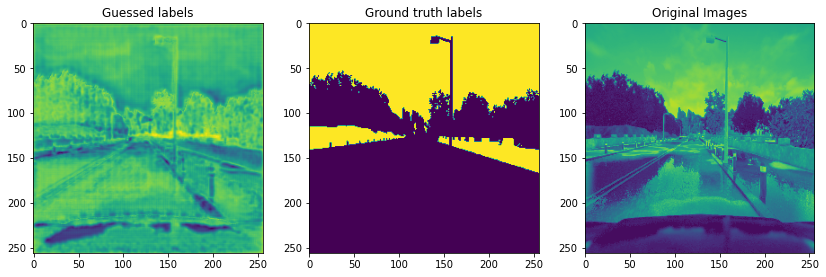

<Figure size 432x288 with 0 Axes>

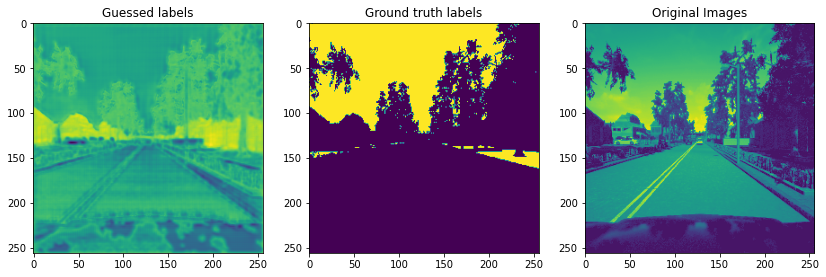

<Figure size 432x288 with 0 Axes>

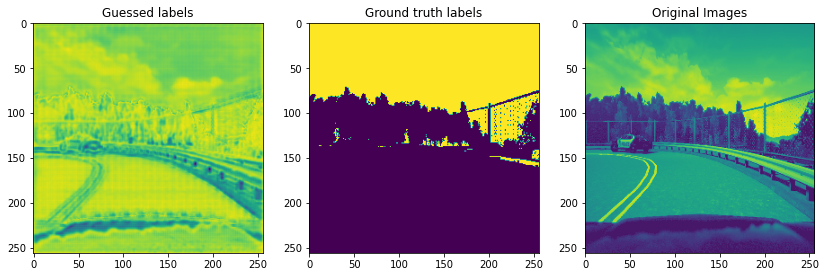

<Figure size 432x288 with 0 Axes>

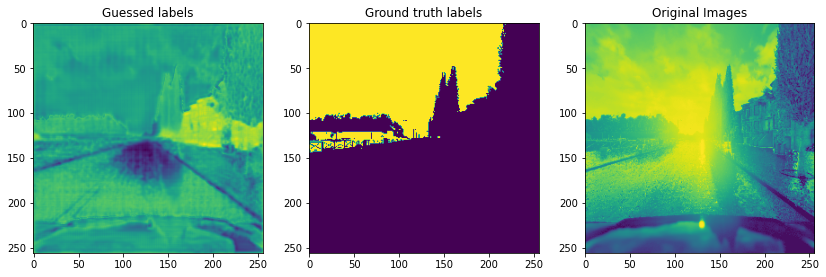

<Figure size 432x288 with 0 Axes>

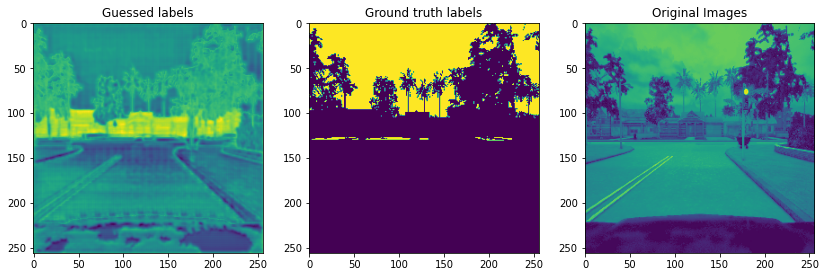

<Figure size 432x288 with 0 Axes>

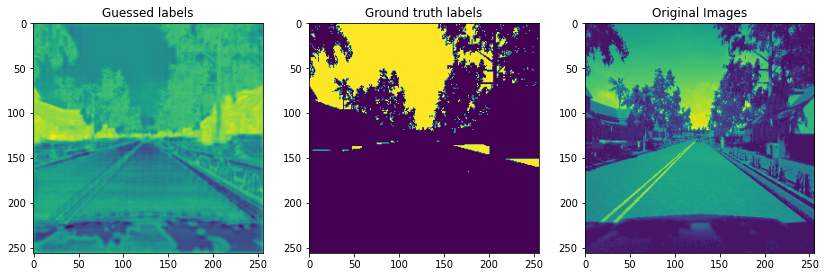

<Figure size 432x288 with 0 Axes>

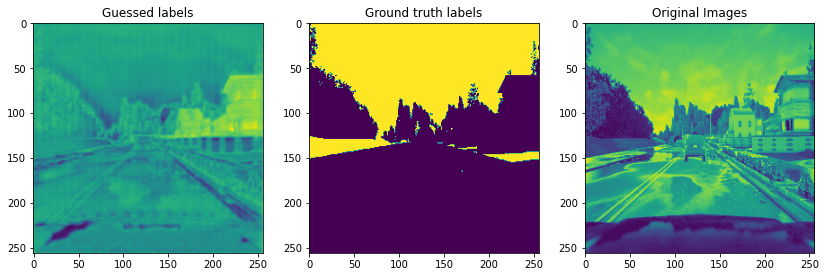

<Figure size 432x288 with 0 Axes>

In [ ]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    outputs = Umodel(images[0].to(device))
    f, axarr = plt.subplots(1,3, figsize=(14, 7))

    axarr[0].imshow(outputs[0].cpu().detach().numpy()[1,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].cpu().detach().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    axarr[2].imshow(images[0].cpu().detach().numpy()[0,0,:,:])
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break

__2.	Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения.__

In [ ]:
!mkdir -p makeup_lips
!kaggle datasets download -d olekslu/makeup-lips-segmentation-28k-samples
!unzip -qq makeup-lips-segmentation-28k-samples.zip -d makeup_lips/
!rm makeup-lips-segmentation-28k-samples.zip

100% 2.38G/2.38G [00:34<00:00, 41.4MB/s]
100% 2.38G/2.38G [00:34<00:00, 74.3MB/s]


In [ ]:
lips = pd.read_csv("makeup_lips/set-lipstick-original/list.csv")
lips.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [ ]:
print("Widths: ", *lips["width"].unique())
print("Heights: ", *lips["height"].unique())
print("Classes: ", *lips["class"].unique())

Widths:  1280
Heights:  720 675
Classes:  Lips


In [ ]:
path_img_lips = "makeup_lips/set-lipstick-original/720p/"
path_mask_lips = "makeup_lips/set-lipstick-original/mask/"

lips["filename"] = path_img_lips + lips["filename"]
lips["mask"] = path_mask_lips + lips["mask"]
lips.drop(columns=["width", "height", "class", "xmin", "ymin", "xmax", "ymax"], inplace=True)
for idx in lips.index:
    if not os.path.isfile(lips["filename"][idx]) or not os.path.isfile(lips["mask"][idx]):
        lips.drop(index=idx, inplace=True)

lips.head(5)

,filename,mask
0,makeup_lips/set-lipstick-original/720p/image00...,makeup_lips/set-lipstick-original/mask/mask000...
1,makeup_lips/set-lipstick-original/720p/image00...,makeup_lips/set-lipstick-original/mask/mask000...
2,makeup_lips/set-lipstick-original/720p/image00...,makeup_lips/set-lipstick-original/mask/mask000...
3,makeup_lips/set-lipstick-original/720p/image00...,makeup_lips/set-lipstick-original/mask/mask000...
4,makeup_lips/set-lipstick-original/720p/image00...,makeup_lips/set-lipstick-original/mask/mask000...


In [ ]:
class LipsDataset(Dataset):
    def __init__(self, data_info):
        self.data_info = data_info
        self.image_arr = self.data_info.iloc[:, 0]
        self.label_arr = self.data_info.iloc[:, 1]
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        img = torch.as_tensor(img)/255  
        img = img.unsqueeze(0).permute(0,3,1,2)
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic') 
        
        lab = np.mean(np.asarray(plt.imread(self.label_arr[index])), axis=2)
        x_out = torch.as_tensor(np.where(lab == 0, 0, 1)).unsqueeze(0).float()
        x_other = torch.abs(x_out - 1)
        x_out =  torch.cat((x_out, x_other), dim=0)
        
        lab = x_out.unsqueeze(0)
        lab = F.interpolate(input=lab, size=256, mode='nearest')     
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [ ]:
X_train_lips, X_test_lips = train_test_split(lips, test_size=0.3)

X_train_lips.reset_index(drop=True, inplace=True)
X_test_lips.reset_index(drop=True, inplace=True)

train_data_lips = LipsDataset(X_train_lips)
test_data_lips = LipsDataset(X_test_lips)

train_data_loader_lips = DataLoader(train_data_lips, batch_size=1, shuffle=True)
test_data_loader_lips = DataLoader(test_data_lips, batch_size=1, shuffle=False)

__3.	И затем обучить Модель на выбор из segmentation_models_pytorch__

In [ ]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 61kB 2.8MB/s 
     |████████████████████████████████| 163kB 10.0MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=d45ef13033fbf935f3f70b2be9c8ebfba92eba8cba0a1aae3e8d737d0d9918d4
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60964 sha256=cb3d6ff1800499c56cd449f92e5e177cd0f4585537814f1e5ebba74660d835e5
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [12]:
import segmentation_models_pytorch as smp

# создание модели
segmodel = smp.Unet('resnet18', classes=2, activation='softmax').to(device)
learning_rate = 0.001
optimizer = torch.optim.Adam(segmodel.parameters(), lr=learning_rate)

epoch_losses = []

for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for data in train_data_loader_lips:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = criterion(outputs, labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 5000 == 4999:    # print every 5000 mini-batches
            print(f'Epoch: {epoch+1}, batchcount: {t+1}, avg. loss for last 5000 images: {running_loss/5000}')
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: {np.mean(epoch_loss)}', f' time = {time2-time1} sec')
    epoch_losses.append(epoch_loss)

/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Epoch: 1, batchcount: 5000, avg. loss for last 5000 images: 0.5675503833651543
Epoch: 1, batchcount: 10000, avg. loss for last 5000 images: 1.1347883075356484
Epoch: 1, batchcount: 15000, avg. loss for last 5000 images: 1.7017907700896262
Epoch 1, loss: 0.5671797641578624  time = 2493.7370188236237 sec
Epoch: 2, batchcount: 5000, avg. loss for last 5000 images: 0.5668013969659805
Epoch: 2, batchcount: 10000, avg. loss for last 5000 images: 1.1336654397249222
Epoch: 2, batchcount: 15000, avg. loss for last 5000 images: 1.7007742884993553
Epoch 2, loss: 0.5669549355541267  time = 2469.6784205436707 sec
Epoch: 3, batchcount: 5000, avg. loss for last 5000 images: 0.5665194575428962
Epoch: 3, batchcount: 10000, avg. loss for last 5000 images: 1.1336131904244422
Epoch: 3, batchcount: 15000, avg. loss for last 5000 images: 1.7004725660681725
Epoch 3, loss: 0.5669389923618463  time = 2494.8922481536865 sec
Epoch: 4, batchcount: 5000, avg. loss for last 5000 images: 0.5666210876822472
Epoch: 4,

/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


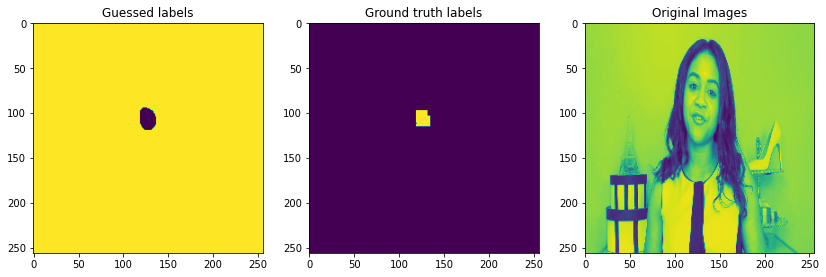

<Figure size 432x288 with 0 Axes>

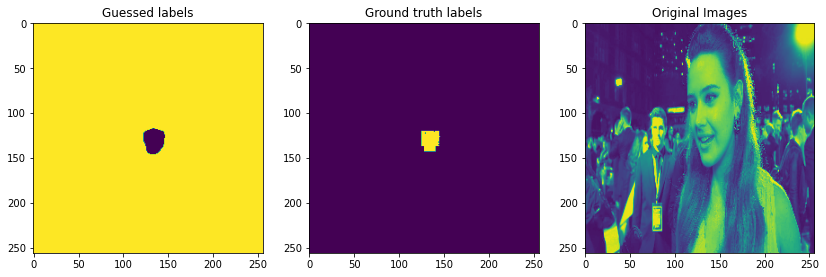

<Figure size 432x288 with 0 Axes>

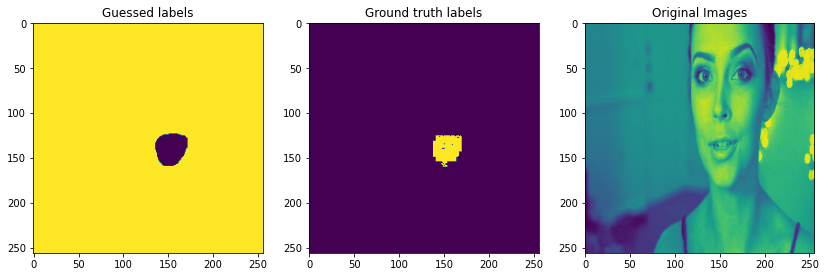

<Figure size 432x288 with 0 Axes>

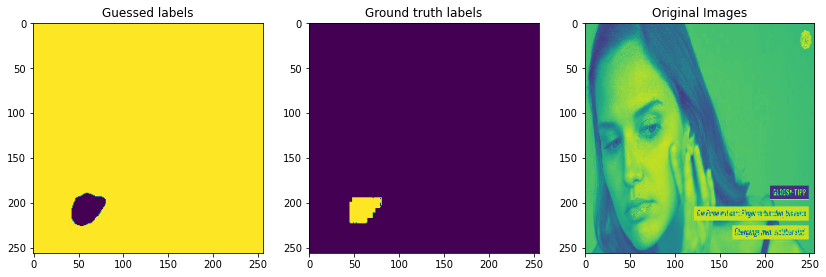

<Figure size 432x288 with 0 Axes>

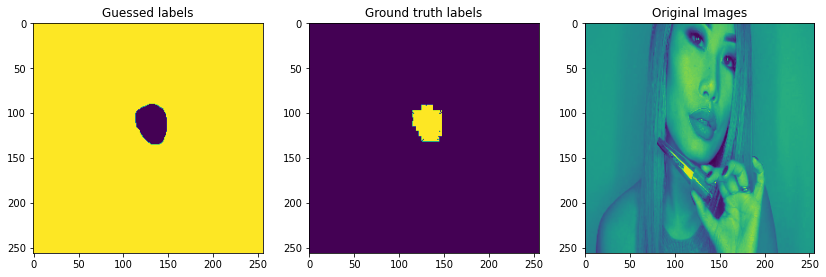

<Figure size 432x288 with 0 Axes>

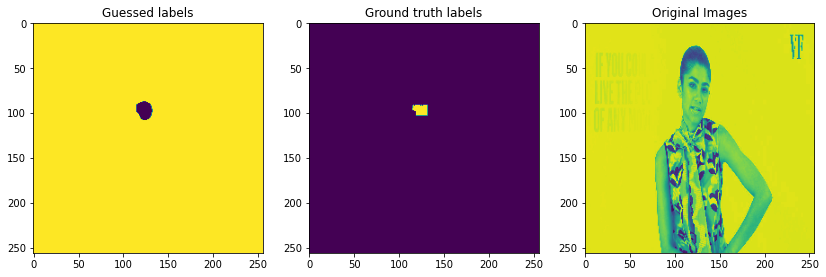

<Figure size 432x288 with 0 Axes>

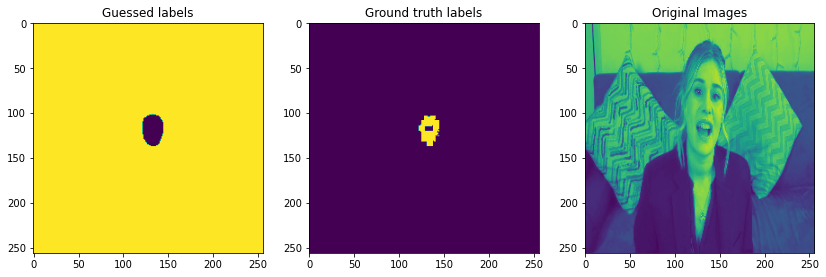

<Figure size 432x288 with 0 Axes>

In [13]:
i = 0
for data in test_data_loader_lips:
    images, labels = data
    outputs = segmodel(images[0].cuda())
    f, axarr = plt.subplots(1,3, figsize=(14, 7))

    axarr[0].imshow(outputs[0].cpu().detach().numpy()[1,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].cpu().detach().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    axarr[2].imshow(images[0].cpu().detach().numpy()[0,0,:,:])
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break
    i+=1